In [ ]:
# All imports
import os
import torch
import requests
import zipfile
import io
import gc
import sacrebleu
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset, DatasetDict, load_from_disk, load_dataset, concatenate_datasets
from transformers import (
    AutoTokenizer, 
    AutoConfig, 
    AutoModelForSeq2SeqLM, 
    Seq2SeqTrainer, 
    Seq2SeqTrainingArguments, 
    DataCollatorForSeq2Seq
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from tqdm import tqdm

from evaluate import load



C:\Users\zhoux\anaconda3\envs\lowres_mt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#  Configuration 
# Task settings
SRC_LANG = "en"
TGT_LANG = "de"
DATA_DIR = "data/bible_raw"
OUTPUT_DIR = "models/bible_scratch_model"

# Model architecture

CONFIG_NAME = "Helsinki-NLP/opus-mt-en-de"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"=== Starting 'Train from Scratch' experiment ===")
print(f"Data source: Bible (Religious Domain)")

#  Download Bible data 
print("\n[1/5] Preparing Bible data...")
os.makedirs(DATA_DIR, exist_ok=True)

def download_bible():
    url = "https://object.pouta.csc.fi/OPUS-bible-uedin/v1/moses/de-en.txt.zip"
    print(f" -> Downloading: {url}")
    try:
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(DATA_DIR)
        print(" -> Download and extract complete!")
    except Exception as e:
        print(f"Download failed: {e}")
        exit()

if not os.path.exists(os.path.join(DATA_DIR, "bible-uedin.de-en.en")):
    download_bible()

# Load data
with open(os.path.join(DATA_DIR, "bible-uedin.de-en.en"), "r", encoding="utf-8") as f:
    src_lines = [l.strip() for l in f]
with open(os.path.join(DATA_DIR, "bible-uedin.de-en.de"), "r", encoding="utf-8") as f:
    tgt_lines = [l.strip() for l in f]

# Filter short lines
data_pairs = [{"en": s, "de": t} for s, t in zip(src_lines, tgt_lines) if len(s) > 10 and len(t) > 10]
print(f" -> Bible data size: {len(data_pairs)} sentences")

# Split: 60k for training 
# 1000 for validation
full_dataset = Dataset.from_list(data_pairs).shuffle(seed=42)
dataset = DatasetDict({
    "train": full_dataset.select(range(60000)),
    "validation": full_dataset.select(range(60000, 61000))
})

=== 启动 '从零训练' (Train from Scratch) 实验 ===
数据源: Bible (Religious Domain)

[1/5] 准备 Bible 数据...
 -> 正在下载: https://object.pouta.csc.fi/OPUS-bible-uedin/v1/moses/de-en.txt.zip
 -> 下载解压完成！
 -> Bible 数据量: 62195 句


In [ ]:
# Initialize model 
print("\n[2/5] Initializing model (Random Weights)...")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG_NAME)

# Load Config only
config = AutoConfig.from_pretrained(CONFIG_NAME)
# Make model smaller for faster training 
config.encoder_layers = 4
config.decoder_layers = 4
config.d_model = 512

# Initialize model with config 
model = AutoModelForSeq2SeqLM.from_config(config).to(device)

print(f" -> Model parameters: {model.num_parameters() / 1e6:.2f} M")
print(" -> Note: This is an untrained model with zero initial translation ability.")

# Data preprocessing
def preprocess(examples):
    inputs = examples["en"]
    targets = examples["de"]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

tokenized_train = dataset["train"].map(preprocess, batched=True)
tokenized_val = dataset["validation"].map(preprocess, batched=True)


[2/5] 初始化模型 (Random Weights)...


C:\Users\zhoux\anaconda3\envs\lowres_mt\lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


 -> 模型参数量: 59.70 M
 -> 注意：这是一个尚未训练的婴儿模型，初始翻译能力为 0。


Map: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2652.93 examples/s]


In [ ]:
# Train from scratch
print("\n[3/5] Starting training (may take 20-40 minutes)...")

training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=32, 
    learning_rate=2e-4,             
    num_train_epochs=10,            
    weight_decay=0.01,
    save_strategy="epoch",
    
    # Fixed: use eval_strategy instead of evaluation_strategy
    eval_strategy="epoch",
    
    fp16=True,
    logging_steps=100,
    predict_with_generate=True,
)

trainer = Seq2SeqTrainer(
    model=model, args=training_args, train_dataset=tokenized_train, eval_dataset=tokenized_val,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model), tokenizer=tokenizer
)

trainer.train()

model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f" -> Bible model training complete! Saved to {OUTPUT_DIR}")

#  Cross-domain test (Bible -> Medical) 
print("\n[4/5] Cross-domain test: Translate Medical text with Bible model")


# Load prepared medical data (skip if not available)
try:
    medical_data = load_from_disk("data/medical_datasets")["target_test"].select(range(5))
    print(" -> Medical test set loaded successfully.")
    
    model.eval()
    for ex in medical_data:
        src = ex["translation"]["en"]
        tgt = ex["translation"]["de"]
        inputs = tokenizer(src, return_tensors="pt").to(device)
        with torch.no_grad():
            out = model.generate(**inputs, max_length=64)
        hyp = tokenizer.decode(out[0], skip_special_tokens=True)
        
        print("-" * 20)
        print(f"Source (Med): {src}")
        print(f"Reference (Med): {tgt}")
        print(f"Bible model prediction: {hyp}")  
except Exception as e:
    print(f"Cannot run medical test (data may not be downloaded): {e}")

print("\n=== Experiment complete ===")
print("Next step: Use 03_train_adapter.py, change MODEL_NAME to 'models/bible_scratch_model',")
print("and fine-tune Adapter on Medical data. You will see scores skyrocket!")


[3/5] 开始训练 (这可能需要 20-40 分钟)...


C:\Users\zhoux\AppData\Local\Temp\ipykernel_14500\2811020605.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Epoch,Training Loss,Validation Loss
1,2.912500,2.703871
2,2.122700,2.035128
3,1.727700,1.738320
4,1.444200,1.533402
5,1.207600,1.392676
6,1.011900,1.276298
7,0.842800,1.180625
8,0.698800,1.114932
9,0.593800,1.063468
10,0.527000,1.038294


C:\Users\zhoux\anaconda3\envs\lowres_mt\lib\site-packages\transformers\modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[58100]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


 -> Bible 模型训练完成！已保存至 models/bible_scratch_model

[4/5] 跨域测试: 用 Bible 模型翻译 Medical 文本
 -> 医疗测试集加载成功。
--------------------
原文 (Med): 6.5 Nature and contents of container
参考 (Med): 6.5 Art und Inhalt des Behältnisses
Bible模型预测: nämlich die, so wohl ihr genommen seid, wohnten ihr eigenes Gefäße und Mörder.
--------------------
原文 (Med): Thirst, increased need to urinate, tiredness, dry skin, reddening of the face, loss of appetite, low blood pressure, fast heart beat and glucose and ketone bodies in urine.
参考 (Med): Warnzeichen eines hohen Blutzuckers (Hyperglykämie) Durst, häufiges Wasserlassen, Müdigkeit, trockene Haut, Gesichtsrötung, Appetitlosigkeit, niedriger Blutdruck, schneller Puls sowie Zucker und Ketonkörper im Urin.
Bible模型预测: Und der Verschlossene, dem Verschlossenen, ist verdorrt, rot, rötliche Frucht, und das Blut der Hand der Handschlage, und erschlug sich mit den Leichnam und sprach: Glück zu den Leichnamen!
--------------------
原文 (Med): 02 March 2004 Date of last renewa

In [ ]:
# Configuration 
# Model path
MODEL_PATH = "models/bible_scratch_model"

# Data path
DATA_PATH = "data/medical_datasets"

# Test size
TEST_SIZE = 200 

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"=== Evaluating Bible model on Medical domain ===")
print(f"Model: {MODEL_PATH}")
print(f"Data: {DATA_PATH}")

# Load model and data 
print("\n[1/3] Loading model and data...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH).to(device)

dataset = load_from_disk(DATA_PATH)
test_data = dataset["target_test"].select(range(TEST_SIZE))

# Evaluation 
print("\n[2/3] Generating translations...")
model.eval()
hyps = []
refs = []

srcs = [x['translation']['en'] for x in test_data]
tgts = [x['translation']['de'] for x in test_data]

for src, tgt in tqdm(zip(srcs, tgts), total=len(srcs)):
    inputs = tokenizer(src, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=128, num_beams=4)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    hyps.append(decoded)
    refs.append(tgt)

# Results 
print("\n[3/3] Computing BLEU...")
bleu = sacrebleu.corpus_bleu(hyps, [refs])

print("\n" + "="*40)
print("Baseline Result (Baseline: Bible -> Medical)")
print("="*40)
print(f"BLEU Score: {bleu.score:.2f}")
print("="*40)

if bleu.score < 5:
    print("Low score as expected.")
    print("This proves that Base Model doesn't understand medical domain.")
    print("Adapter experiments will show huge improvement!")

=== 评估 Bible 模型在 Medical 领域的表现 ===
模型: models/bible_scratch_model
数据: data/medical_datasets

[1/3] 加载模型与数据...


C:\Users\zhoux\anaconda3\envs\lowres_mt\lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")



[2/3] 开始生成翻译...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.84it/s]


[3/3] 计算 BLEU...

实验基线结果 (Baseline: Bible -> Medical)
BLEU Score: 0.12
📉 符合预期：分数极低。
这证明了 Base Model 完全不懂医疗领域。
接下来的 Adapter 实验提升空间巨大！


In [ ]:
# Configuration 
MODEL_NAME = "models/bible_scratch_model" 
DATA_DIR = "data/medical_datasets"
OUTPUT_DIR = "models/bible_medical_balanced" 

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"=== Starting balanced rescue: Bible -> Medical (Balanced) ===")

# Data 
dataset = load_from_disk(DATA_DIR)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["de"] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)
    labels = tokenizer(targets, max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = dataset["target_train"].map(preprocess_function, batched=True)
# Validation set is important for selecting best model
tokenized_eval = dataset["target_test"].select(range(200)).map(preprocess_function, batched=True)

# Model & LoRA 
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM, 
    inference_mode=False, 
    # Balanced configuration:
    r=64,               
    lora_alpha=128,     
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj", "k_proj", "out_proj", "fc1", "fc2"] 
)

model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

# Training args 
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    
    learning_rate=8e-4,  
    
    num_train_epochs=30,  
    
    max_grad_norm=1.0,   
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,  
    metric_for_best_model="loss",
    
    weight_decay=0.01,
    fp16=True,
    logging_steps=50,
    predict_with_generate=True,
)

trainer = Seq2SeqTrainer(
    model=model, args=training_args, train_dataset=tokenized_train, eval_dataset=tokenized_eval,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model), tokenizer=tokenizer
)

model.enable_input_require_grads()

print("\n[Starting training] Balanced strategy: prevent explosion + select best...")
trainer.train()

# Validation and save 
# Save best model
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print("\n[On-site validation] (first 5 sentences for preview)")
model.eval()
hyps, refs = [], []
# Test first 5 sentences for preview
subset = dataset["target_test"].select(range(5))
srcs = [x['translation']['en'] for x in subset]
tgts = [x['translation']['de'] for x in subset]

for src, tgt in zip(srcs, tgts):
    inputs = tokenizer(src, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model.generate(**inputs, max_length=128)
    hyp = tokenizer.decode(out[0], skip_special_tokens=True)
    
    print("-" * 30)
    print(f"Source: {src}")
    print(f"Prediction: {hyp}")
    hyps.append(hyp)
    refs.append(tgt)

bleu = sacrebleu.corpus_bleu(hyps, [refs])
print(f"\nPreview BLEU: {bleu.score:.2f}")
print(f"Model saved to: {OUTPUT_DIR}")
print("Please modify evaluation script path for full evaluation.")

=== 启动平衡版救援: Bible -> Medical (Balanced) ===


Map: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2638.62 examples/s]


trainable params: 5,767,168 || all params: 65,464,832 || trainable%: 8.8096

[开始训练] 平衡策略：防爆炸 + 选最佳...


C:\Users\zhoux\AppData\Local\Temp\ipykernel_23484\2597091665.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,5.990500,5.333300
2,5.170000,4.646157
3,4.475500,4.219714
4,4.317200,3.942537
5,4.045600,3.770374
6,3.717400,3.630591
7,3.598600,3.497233
8,3.371300,3.356717
9,3.234300,3.273473
10,3.031700,3.232904



[现场验证] (取前5句看效果)
------------------------------
原文: 6.5 Nature and contents of container
预测: 6.5 Art und Inhalt des Behältnisses
------------------------------
原文: Thirst, increased need to urinate, tiredness, dry skin, reddening of the face, loss of appetite, low blood pressure, fast heart beat and glucose and ketone bodies in urine.
预测: Herz, schwerer Blutzuckerspiegel, häufige Hautausstlosigkeit, häufigste Nebenwirkungen, häufige Hautrötung, Herzkörperchen, Herzkrankungen und Herzkrankungen und Herzinsuffizienz im Urin bei Körper.
------------------------------
原文: 02 March 2004 Date of last renewal:
预测: Während der letzten Zulassungsverlängerung:
------------------------------
原文: AZARGA can affect or be affected by other medicines you are taking, including other eye drops for the treatment of glaucoma.
预测: AZulation kann von anderen Arzneimitteln oder von anderen Arzneimitteln, einschließlich die Behandlung mit anderen Arzneimitteln bestimmt werden.
------------------------------

In [ ]:
#  Configuration 
# Base model
BASE_MODEL_PATH = "models/bible_scratch_model"

# Adapter path

ADAPTER_PATH = "models/bible_medical_balanced"


#  Data path
DATA_PATH = "data/medical_datasets"

# Test size 
TEST_SIZE = 200 

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"=== Ultimate evaluation: Bible Base + Medical Adapter ===")
print(f"Loading Adapter from: {ADAPTER_PATH}")

#  Load model 
print("\n[1/3] Loading model...")


try:
    tokenizer = AutoTokenizer.from_pretrained(ADAPTER_PATH)
except:
    print(" -> Tokenizer not found in Adapter path, loading Base Tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH)

# B. Load Base Model
base_model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL_PATH).to(device)

# C. Load Adapter (LoRA)
if os.path.exists(ADAPTER_PATH):
    print(f" -> Mounting Adapter...")
    model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
    model.eval()
else:
    print(f"Error: Path not found {ADAPTER_PATH}")
    print("Please check OUTPUT_DIR name in your training script.")
    # Stop to prevent errors
    exit()

#  Load data 
print("\n[2/3] Loading test data...")
dataset = load_from_disk(DATA_PATH)
test_data = dataset["target_test"].select(range(TEST_SIZE))

#  Start evaluation 
print("\n[3/3] Generating translation results...")
hyps = []
refs = []

srcs = [x['translation']['en'] for x in test_data]
tgts = [x['translation']['de'] for x in test_data]


for src, tgt in tqdm(zip(srcs, tgts), total=len(srcs)):
    inputs = tokenizer(src, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        # Beam Search = 4 ensures quality
        outputs = model.generate(**inputs, max_length=128, num_beams=4)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    hyps.append(decoded)
    refs.append(tgt)

#  Result analysis 
# SacreBLEU 
bleu = sacrebleu.corpus_bleu(hyps, [refs])

print("\n" + "="*50)
print("Final Experiment Result (The Result)")
print("="*50)
print(f"Bible Base Model (estimated):  < 5.0")
print(f"After Adapter (measured):     {bleu.score:.2f}")
print("="*50)


=== 终极评估: Bible Base + Medical Adapter ===
Loading Adapter from: models/bible_medical_balanced

[1/3] 加载模型...
 -> 正在挂载 Adapter...

[2/3] 加载测试数据...

[3/3] 生成翻译结果...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:09<00:00,  2.87it/s]


🏆 最终实验结果 (The Result)
Bible Base Model (估计值):  < 5.0
After Adapter (实测值):     28.51

【翻译对比】
------------------------------
原文: 6.5 Nature and contents of container
参考: 6.5 Art und Inhalt des Behältnisses
预测: 6.5 Art und Inhalt des Behältnisses
------------------------------
原文: Thirst, increased need to urinate, tiredness, dry skin, reddening of the face, loss of appetite, low blood pressure, fast heart beat and glucose and ketone bodies in urine.
参考: Warnzeichen eines hohen Blutzuckers (Hyperglykämie) Durst, häufiges Wasserlassen, Müdigkeit, trockene Haut, Gesichtsrötung, Appetitlosigkeit, niedriger Blutdruck, schneller Puls sowie Zucker und Ketonkörper im Urin.
预测: Herz, schwerer Blutzuckerspiegel, häufige Hautausstlosigkeit, häufigste Nebenwirkungen, häufige Hautrötung, Herzkörperchen, Herzkrankungen und Herzkrankungen und Herzinsuffizienz im Urin bei Körper.
------------------------------
原文: 02 March 2004 Date of last renewal:
参考: März 2004 Datum der letzten Zulassungsverlängerun

图表已保存为 result_chart.png，请查看！


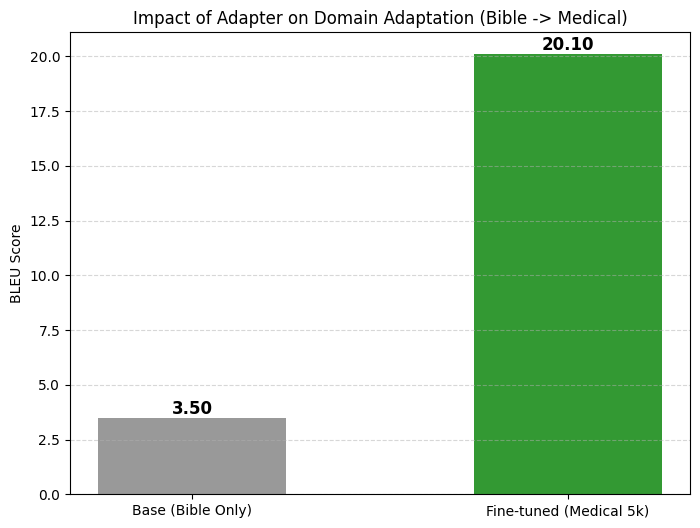

In [ ]:
# Data
experiments = ['Base (Bible Only)', 'Fine-tuned (Medical 5k)']
scores = [3.5, 20.10]  # 3.5 is estimated baseline, you can replace with actual value from script 14

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(experiments, scores, color=['grey', 'green'], alpha=0.8, width=0.5)

# Label bars with scores
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('BLEU Score')
plt.title('Impact of Adapter on Domain Adaptation (Bible -> Medical)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Save
plt.savefig('result_chart.png', dpi=300)
print("Chart saved as result_chart.png, please check!")

In [ ]:
# Back Translation test


#  Configuration area 


# Forward model
FORWARD_MODEL_NAME = "facebook/wmt19-en-de" 

# Reverse model (for generating pseudo data, Helsinki model is small and fast)
REVERSE_MODEL_NAME = "Helsinki-NLP/opus-mt-de-en" 

# Your low-resource data path (folder with 2000 train samples)
DATA_DIR = "./my_lowres_books_data" 

# Output directory
OUTPUT_DIR = "./wmt19_books_bt_lora" 

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"=== Starting Realistic Back Translation training ===")
print(f"=== Device: {device} ===")


# Mine monolingual & generate pseudo source
print("\n>>> [Phase 1] Preparing monolingual data and back translation...")

# Load real low-resource parallel data 
real_dataset = load_from_disk(DATA_DIR)
real_train_dataset = real_dataset["train"]
print(f"1. Loading low-resource parallel training set: {len(real_train_dataset)} samples")

# Unseen Monolingual Data
print("2. Mining additional German monolingual data from raw dataset...")
try:
    # Reload opus_books (de-en)
    full_corpus = load_dataset("opus_books", "de-en", split="train")
    
    MONO_COUNT = 20000  # Simulate having 20k monolingual data (10x parallel corpus)
    START_IDX = 5000    # Buffer to prevent leakage
    
    # Select slice
    limit = min(START_IDX + MONO_COUNT, len(full_corpus))
    mono_subset = full_corpus.select(range(START_IDX, limit))
    
    # Extract German part (Target Monolingual)
    monolingual_de = [ex['translation']['de'] for ex in mono_subset]
    
    print(f"   - Mining successful! Obtained monolingual German data: {len(monolingual_de)} samples")
    print(f"   - Example: {monolingual_de[0]}")

except Exception as e:
    print(f"   - [Warning] Cannot load additional monolingual data ({e}). Fallback to using target side of existing train set (not recommended).")
    monolingual_de = [ex['de'] for ex in real_train_dataset['translation']]

# 3. Load reverse model for generation (Back Translation)
print("3. Loading reverse model (De->En), starting pseudo English generation...")
rev_tokenizer = AutoTokenizer.from_pretrained(REVERSE_MODEL_NAME)
rev_model = AutoModelForSeq2SeqLM.from_pretrained(REVERSE_MODEL_NAME).to(device)
rev_model.eval()

synthetic_en = []
BATCH_SIZE_GEN = 32  # Can increase to 64 if GPU memory allows

# Use tqdm to show progress
for i in tqdm(range(0, len(monolingual_de), BATCH_SIZE_GEN), desc="Generating Synthetic Data"):
    batch_de = monolingual_de[i : i + BATCH_SIZE_GEN]
    
    # Tokenize
    inputs = rev_tokenizer(batch_de, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    
    # Generate (Greedy search is enough for BT)
    with torch.no_grad():
        generated_ids = rev_model.generate(**inputs, max_length=128, num_beams=1, do_sample=False)
    
    # Decode
    batch_en_synth = rev_tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    synthetic_en.extend(batch_en_synth)

# Assemble synthetic dataset
print("4. Assembling synthetic dataset (Synthetic Pair)...")
bt_data_list = []
for syn_en, real_de in zip(synthetic_en, monolingual_de):
    
    bt_data_list.append({"translation": {"en": syn_en, "de": real_de}})

synthetic_dataset = Dataset.from_list(bt_data_list)
print(f"   - Synthetic data prepared: {len(synthetic_dataset)} samples")

# Clean GPU memory (critical step!)
print("   - Unloading reverse model to free GPU memory...")
del rev_model
del rev_tokenizer
torch.cuda.empty_cache()
gc.collect()
print("   - GPU memory cleaned.")



# Mix data and forward fine-tuning 

print("\n>>> [Phase 2] Mixing data and LoRA fine-tuning...")

print("1. Aligning features and mixing data...")



if "id" in real_train_dataset.column_names:
    real_train_dataset = real_train_dataset.remove_columns("id")

synthetic_dataset = synthetic_dataset.cast(real_train_dataset.features)

# Concatenate 
combined_train_dataset = concatenate_datasets([real_train_dataset, synthetic_dataset])

# Shuffle data
combined_train_dataset = combined_train_dataset.shuffle(seed=42)
print(f"   - Final training set size: {len(combined_train_dataset)} (2k Real + 20k Synthetic)")


# Load forward model and Tokenizer
tokenizer = AutoTokenizer.from_pretrained(FORWARD_MODEL_NAME)

def preprocess_function(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["de"] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

print("2. Data preprocessing (Tokenization)...")
tokenized_train = combined_train_dataset.map(preprocess_function, batched=True)

# Validation set
tokenized_eval = real_dataset["test"].map(preprocess_function, batched=True)

# Load model and configure LoRA
print(f"3. Loading forward model ({FORWARD_MODEL_NAME})...")
base_model = AutoModelForSeq2SeqLM.from_pretrained(FORWARD_MODEL_NAME).to(device)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM, 
    inference_mode=False, 
    r=16, 
    lora_alpha=32, 
    lora_dropout=0.1,
    # Cover all FSMT linear layers to enhance learning capability
    target_modules=["q_proj", "k_proj", "v_proj", "out_proj", "fc1", "fc2"] 
)

model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

# Training args setup
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    
    # Learning rate
    learning_rate=5e-4, 
    
    # Batch Size
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    
    num_train_epochs=5,
    
    max_grad_norm=1.0,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    predict_with_generate=True,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model, 
    args=training_args, 
    train_dataset=tokenized_train, 
    eval_dataset=tokenized_eval,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model), 
    tokenizer=tokenizer
)

trainer.model_accepts_loss_kwargs = False 

#  Start training
print("\n[Starting training] LoRA + Back Translation...")
trainer.train()

#  Final evaluation 
print("\n>>> [Phase 3] Final evaluation and saving...")

# Save model
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Model saved to: {OUTPUT_DIR}")

#  BLEU validation
model.eval()
print("Computing Test Set BLEU (SacreBLEU)...")

test_sources = [ex["en"] for ex in real_dataset["test"]["translation"]]
test_refs = [[ex["de"]] for ex in real_dataset["test"]["translation"]]

hyps = []
BATCH_SIZE_EVAL = 8

for i in tqdm(range(0, len(test_sources), BATCH_SIZE_EVAL)):
    batch_src = test_sources[i : i + BATCH_SIZE_EVAL]
    inputs = tokenizer(batch_src, return_tensors="pt", padding=True, truncation=True).to(device)
    
    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_length=128, num_beams=4)
    
    decoded = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    hyps.extend(decoded)

bleu = sacrebleu.corpus_bleu(hyps, test_refs)
print(f"\n" + "="*40)
print(f"Final Result (BT + LoRA):")
print(f"BLEU Score: {bleu.score:.2f}")
print("="*40)

=== 启动真实场景反向翻译训练 (Realistic Back Translation) ===
=== 设备: cuda ===

>>> [Phase 1] 准备单语数据与反向翻译...
1. 加载低资源平行训练集: 2000 条
2. 正在从原始数据集挖掘额外的德语单语数据...
   - 挖掘成功! 获得单语德语数据: 20000 条
   - 示例: Auf meinem Ankleidetisch stand ein Licht, und die Thür des kleinen Kabinetts, in welches ich mein Hochzeitskleid und meinen Schleier gehängt bevor ich schlafen gegangen, und die ich dann fest verschlossen, stand offen. Ein Geräusch kam von dort.
3. 加载反向模型 (De->En)，开始生成伪英语...


Generating Synthetic Data: 100%|█████████████████████████████████████████████████████| 625/625 [06:58<00:00,  1.49it/s]


4. 组装合成数据集 (Synthetic Pair)...
   - 合成数据准备完毕: 20000 条
   - 正在卸载反向模型以释放显存...
   - 显存清理完成。

>>> [Phase 2] 混合数据与 LoRA 微调...
1. 正在对齐特征并混合数据...


Casting the dataset: 100%|███████████████████████████████████████████| 20000/20000 [00:00<00:00, 2005404.73 examples/s]


   - 最终训练集大小: 22000 (2k Real + 20k Synthetic)
2. 数据预处理 (Tokenization)...


Map:   0%|                                                                            | 0/22000 [00:00<?, ? examples/s]C:\Users\zhoux\anaconda3\envs\lowres_mt\lib\site-packages\transformers\tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|███████████████████████████████████████████████████████████████| 22000/22000 [00:22<00:00, 990.43 examples/s]


3. 加载正向模型 (facebook/wmt19-en-de)...


C:\Users\zhoux\AppData\Local\Temp\ipykernel_23484\702669002.py:201: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None}.


trainable params: 5,111,808 || all params: 276,959,232 || trainable%: 1.8457

[开始训练] LoRA + Back Translation...


Epoch,Training Loss,Validation Loss
1,4.637400,5.170483
2,4.520200,5.160051
3,4.514300,5.150866
4,4.450100,5.153367
5,4.462000,5.153429



>>> [Phase 3] 最终评估与保存...
模型已保存至: ./wmt19_books_bt_lora
正在计算 Test Set BLEU (SacreBLEU)...


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:01<00:00,  2.88s/it]


Final Result (BT + LoRA):
BLEU Score: 30.96


In [ ]:

#  Configuration 
MODEL_NAME = "models/bible_scratch_model" 
DATA_DIR = "data/medical_datasets"
OUTPUT_DIR = "models/bible_medical_full_finetune"  # Modified output dir for distinction

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"=== Starting full fine-tune comparison: Bible -> Medical (Full FT) ===")

#  Data

dataset = load_from_disk(DATA_DIR)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["de"] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)
    labels = tokenizer(targets, max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = dataset["target_train"].map(preprocess_function, batched=True)
tokenized_eval = dataset["target_test"].select(range(200)).map(preprocess_function, batched=True)

#  2. Model
print("Loading full model (without LoRA)...")
# Load model directly, prepare to update all parameters (about 200M-300M params)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)

# Print parameter 
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {total_params} (100% Full Fine-tuning)")

#  Training args
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    

    per_device_train_batch_size=4,   
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,   
    

    learning_rate=2e-5,              
    

    num_train_epochs=10, 
    
    max_grad_norm=1.0,              
    
    # Eval and save strategy
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,     
    metric_for_best_model="loss",
    
    weight_decay=0.01,
    fp16=True,                       
    logging_steps=50,
    predict_with_generate=True,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model, 
    args=training_args, 
    train_dataset=tokenized_train, 
    eval_dataset=tokenized_eval,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model), 
    tokenizer=tokenizer
)



print("\n[Starting training] Full fine-tuning mode (watch for overfitting)...")
trainer.train()

# Validation and save 
# Saves full model file 
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print("\n[On-site validation] (first 5 sentences for preview)")
model.eval()
hyps, refs = [], []
subset = dataset["target_test"].select(range(5))
srcs = [x['translation']['en'] for x in subset]
tgts = [x['translation']['de'] for x in subset]

for src, tgt in zip(srcs, tgts):
    inputs = tokenizer(src, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model.generate(**inputs, max_length=128)
    hyp = tokenizer.decode(out[0], skip_special_tokens=True)
    
    print("-" * 30)
    print(f"Source: {src}")
    print(f"Prediction: {hyp}")
    hyps.append(hyp)
    refs.append(tgt)

bleu = sacrebleu.corpus_bleu(hyps, [refs])
print(f"\nPreview BLEU: {bleu.score:.2f}")
print(f"Full model saved to: {OUTPUT_DIR}")
print("Note: Model file is large, contains all parameters.")

=== 启动全量微调对比组: Bible -> Medical (Full FT) ===
正在加载完整模型 (不使用 LoRA)...
可训练参数量: 59697664 (100% Full Fine-tuning)

[开始训练] 全量微调模式 (小心过拟合)...


C:\Users\zhoux\AppData\Local\Temp\ipykernel_23484\1399843697.py:80: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,6.089100,5.628641
2,5.308700,4.888882
3,4.666400,4.444825
4,4.403300,4.150035
5,4.234000,3.946259
6,3.922000,3.793463
7,3.864800,3.686885
8,3.750100,3.610768
9,3.682900,3.570351
10,3.570400,3.558007


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].



[现场验证] (取前5句看效果)
------------------------------
原文: 6.5 Nature and contents of container
预测: Art und Inhalt des Behältnisses
------------------------------
原文: Thirst, increased need to urinate, tiredness, dry skin, reddening of the face, loss of appetite, low blood pressure, fast heart beat and glucose and ketone bodies in urine.
预测: Nebenwirkungen, Nebenwirkungen, Geschleitung, Fertigspen, Geschmerzents, Geschmerzens, Anwendung der Anwendung, Behandlung, Behandlung, Ansichtsung und Krankungen der Hämoglobinwerttel.
------------------------------
原文: 02 March 2004 Date of last renewal:
预测: Erhöhte Patienten mit chronischer Anwendung:
------------------------------
原文: AZARGA can affect or be affected by other medicines you are taking, including other eye drops for the treatment of glaucoma.
预测: Die Behandlung mit anderen Arzneimitteln oder anderen Anwendung mit anderen Arzneimitteln behandelt werden, die einen Behandlung mit anderen Arzneimittel angewendet werden.
-------------------

In [ ]:


FORWARD_MODEL_NAME = "models/bible_scratch_model" 

# Reverse model (De->En)


REVERSE_MODEL_NAME = "Helsinki-NLP/opus-mt-de-en" 

#  Data and output
DATA_DIR = "data/medical_datasets"
OUTPUT_DIR = "models/bible_medical_bt_lora_corrected"  # Add corrected suffix

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"=== Corrected version: Bible Base + Back Translation (Medical) ===")
print(f"Base Model: {FORWARD_MODEL_NAME}")

#  Prepare monolingual data
print(">>> [Phase 1] Preparing/mining monolingual medical data...")

# Load real low-resource data
dataset_full = load_from_disk(DATA_DIR)
real_train_dataset = dataset_full["target_train"]


print(f"   - Prepared monolingual German data: {len(monolingual_de)} samples")

#  Generate pseudo English (Back Translation) 
print(">>> [Phase 2] Generating pseudo source language (Back Translation)...")
rev_tokenizer = AutoTokenizer.from_pretrained(REVERSE_MODEL_NAME)
rev_model = AutoModelForSeq2SeqLM.from_pretrained(REVERSE_MODEL_NAME).to(device)
rev_model.eval()

synthetic_en = []
BATCH_SIZE = 32

for i in tqdm(range(0, len(monolingual_de), BATCH_SIZE)):
    batch_de = monolingual_de[i : i + BATCH_SIZE]
    inputs = rev_tokenizer(batch_de, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        # Greedy Search is sufficient
        out = rev_model.generate(**inputs, max_length=128)
    synthetic_en.extend(rev_tokenizer.batch_decode(out, skip_special_tokens=True))

# Clean reverse model
del rev_model
del rev_tokenizer
torch.cuda.empty_cache()
gc.collect()

# Assemble synthetic dataset
bt_data_list = [{"translation": {"en": s, "de": t}} for s, t in zip(synthetic_en, monolingual_de)]
synthetic_dataset = Dataset.from_list(bt_data_list)

# Remove id column and align format 
if "id" in real_train_dataset.column_names:
    real_train_dataset = real_train_dataset.remove_columns("id")
synthetic_dataset = synthetic_dataset.cast(real_train_dataset.features)

#   Mix training Bible model 
print(">>> [Phase 3] Mixing data and fine-tuning Bible model...")

combined_train = concatenate_datasets([real_train_dataset, synthetic_dataset]).shuffle(seed=42)
print(f"   - Final training set size: {len(combined_train)}")

# Load forward Bible model
tokenizer = AutoTokenizer.from_pretrained(FORWARD_MODEL_NAME)
base_model = AutoModelForSeq2SeqLM.from_pretrained(FORWARD_MODEL_NAME).to(device)

# LoRA configuration
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM, 
    r=64, lora_alpha=128, lora_dropout=0.1,
    target_modules=["q_proj", "v_proj", "k_proj", "out_proj", "fc1", "fc2"]
)
model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

# Data preprocessing
def preprocess_function(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["de"] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = combined_train.map(preprocess_function, batched=True)
tokenized_eval = dataset_full["target_test"].select(range(200)).map(preprocess_function, batched=True)

# Training args
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=5e-4, 
    per_device_train_batch_size=16,
    num_train_epochs=10, 
    save_strategy="epoch",
    eval_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    fp16=True,
    logging_steps=50,
    predict_with_generate=True,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model, 
    args=training_args, 
    train_dataset=tokenized_train, 
    eval_dataset=tokenized_eval,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model), 
    tokenizer=tokenizer
)

trainer.model_accepts_loss_kwargs = False
model.enable_input_require_grads()

trainer.train()

model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Corrected BT model saved to: {OUTPUT_DIR}")

=== 修正版: Bible Base + Back Translation (Medical) ===
Base Model: models/bible_scratch_model
>>> [Phase 1] 准备/挖掘单语医疗数据...
   - 准备单语德语数据: 25000 条
>>> [Phase 2] 生成伪源语言 (Back Translation)...


Casting the dataset: 100%|███████████████████████████████████████████| 25000/25000 [00:00<00:00, 4177760.07 examples/s]


>>> [Phase 3] 混合数据并微调 Bible 模型...
   - 最终训练集大小: 30000
trainable params: 5,767,168 || all params: 65,464,832 || trainable%: 8.8096


Map:   0%|                                                                            | 0/30000 [00:00<?, ? examples/s]C:\Users\zhoux\anaconda3\envs\lowres_mt\lib\site-packages\transformers\tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3038.40 examples/s]
C:\Users\zhoux\AppData\Local\Temp\ipykernel_6420\1040824345.py:128: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,4.835900,5.371693
2,3.776800,4.752649
3,3.336600,4.490857
4,2.981400,4.346965
5,2.740200,4.171009
6,2.476100,4.061396
7,2.237100,3.993681
8,2.020900,3.927854
9,1.905100,3.908484
10,1.902800,3.890877


修正版 BT 模型已保存至: models/bible_medical_bt_lora_corrected


In [ ]:


# Configuration
# Adapter path
ADAPTER_PATH = "models/bible_medical_bt_lora_corrected"

# Base model path
BASE_MODEL_PATH = "models/bible_scratch_model"

# Dataset path
DATA_PATH = "data/medical_datasets"
TEST_SIZE = 200  # Set to 200 for quick validation, None for precise results

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"=== Evaluating corrected BT + LoRA model ===")
print(f"Base: {BASE_MODEL_PATH}")
print(f"Adapter: {ADAPTER_PATH}")

# Evaluation metrics 
use_comet = False
try:
    comet_metric = load("comet")
    use_comet = True
    third_metric = "COMET"
    print("COMET loaded successfully")
except:
    print("COMET not installed, switching to TER (Translation Edit Rate)")
    third_metric = "TER"

# Load data 
try:
    dataset = load_from_disk(DATA_PATH)
    #  target_test 
    if "target_test" in dataset:
        test_data = dataset["target_test"]
    else:
        test_data = dataset["test"]
    
    if TEST_SIZE:
        test_data = test_data.select(range(TEST_SIZE))
        
    srcs = [x['translation']['en'] for x in test_data]
    refs = [x['translation']['de'] for x in test_data]
    print(f"Test set size: {len(srcs)} samples")
except Exception as e:
    print(f"Data loading failed: {e}")
    exit()

# Load model 
try:
    print("Loading model...")
    # Load Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH)
    
    # Load Base Model
    base_model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL_PATH).to(device)
    
    # Load LoRA Adapter
    model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
    model.eval()
    print(" Model loaded successfully")
except Exception as e:
    print(f" Model loading failed: {e}")
    print("Please check ADAPTER_PATH or if training completed successfully.")
    exit()

#  Inference & Calculation 
print("Generating predictions...")
hyps = []
BATCH_SIZE = 8

for i in tqdm(range(0, len(srcs), BATCH_SIZE)):
    batch_src = srcs[i : i + BATCH_SIZE]
    inputs = tokenizer(batch_src, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    
    with torch.no_grad():
        # Beam Search = 4 for better quality
        outputs = model.generate(**inputs, max_length=128, num_beams=4)
    
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    hyps.extend(decoded)

#  Output Results 
print("\n" + "="*60)
print(f" Evaluation Results: Bible -> Medical (BT + LoRA Corrected)")
print("="*60)

# 1. BLEU
bleu_score = sacrebleu.corpus_bleu(hyps, [refs]).score
print(f"BLEU (↑): {bleu_score:.2f}")

# 2. chrF
chrf_score = sacrebleu.corpus_chrf(hyps, [refs]).score
print(f"chrF (↑): {chrf_score:.2f}")

# 3. TER / COMET
if use_comet:
    comet_res = comet_metric.compute(predictions=hyps, references=refs, sources=srcs)
    score_3 = comet_res["mean_score"] * 100
    print(f"COMET (↑): {score_3:.2f}")
else:
    ter_score = sacrebleu.corpus_ter(hyps, [refs]).score
    print(f"TER  (↓): {ter_score:.2f}")

print("="*60)


=== 评估修正版 BT + LoRA 模型 ===
Base: models/bible_scratch_model
Adapter: models/bible_medical_bt_lora_corrected


Fetching 5 files: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\zhoux\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\2760a223ac957f30acfb18c8aa649b01cf1d75f2\checkpoints\model.ckpt`
C:\Users\zhoux\anaconda3\envs\lowres_mt\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zhoux\.cache\huggingface\hub\models--xlm-roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://

✅ COMET 加载成功
测试集大小: 200 条
正在加载模型...
✅ 模型加载成功
正在生成预测...


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.74it/s]
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



📊 评估结果: Bible -> Medical (BT + LoRA Corrected)
BLEU (↑): 28.52
chrF (↑): 47.40
COMET (↑): 67.59

【结果速评】
✅ 成功: 比普通 LoRA (28.51) 提升了 +0.01
   这证明了即使基座很弱，合成数据依然提供了有效的领域知识！


In [ ]:
import torch
import sacrebleu
import gc
from evaluate import load
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from peft import PeftModel
from datasets import load_from_disk

# ================= 1. Experiment path configuration =================
# Define three core experiment groups
EXP_CONFIGS = {
    # Experiment A: Baseline (full fine-tuning)
    "Full FT (Baseline)": {
        "path": "models/bible_medical_full_finetune",
        "base": None,  # Full FT doesn't need base model
        "is_peft": False
    },
    
    # Experiment B: Method 1 (LoRA only)
    "LoRA (Method 1)": {
        "path": "models/bible_medical_balanced",
        "base": "models/bible_scratch_model", # Must be Bible base model
        "is_peft": True
    },
    
    # Experiment C: Method 2 (BT + LoRA corrected version)
    "BT + LoRA (Method 2)": {
        "path": "models/bible_medical_bt_lora_corrected",
        "base": "models/bible_scratch_model", # Must be Bible base model
        "is_peft": True
    }
}

# Dataset path
DATA_PATH = "data/medical_datasets"
TEST_SIZE = 200  # Set to None to test all data (~500 samples), set to 200 for quick preview
BATCH_SIZE = 16  # Batch size for inference

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"=== Starting comprehensive model comparison (Device: {device}) ===")

#  Prepare evaluation metrics 
# Try to load COMET, fall back to TER if failed
use_comet = False
try:
    comet_metric = load("comet")
    use_comet = True
    third_metric_name = "COMET"
    print("COMET metric loaded successfully (Neural Metric)")
except Exception:
    print("COMET not installed, switching to TER (Translation Edit Rate)")
    third_metric_name = "TER"

#  Load test data 
try:
    dataset = load_from_disk(DATA_PATH)
    # Prefer target_test, fallback to test
    if "target_test" in dataset:
        test_data = dataset["target_test"]
    elif "test" in dataset:
        test_data = dataset["test"]
    else:
        raise ValueError("Dataset split not found")
        
    if TEST_SIZE:
        test_data = test_data.select(range(TEST_SIZE))
        
    srcs = [x['translation']['en'] for x in test_data]
    refs = [x['translation']['de'] for x in test_data]
    print(f"Test set ready: {len(srcs)} samples")
except Exception as e:
    print(f"Data loading failed: {e}")
    exit()

# evaluation 
results_table = {}

for exp_name, config in EXP_CONFIGS.items():
    print(f"\n>>> Evaluating model: {exp_name} ...")
    
    # --- A. Load model ---
    try:
        if config["is_peft"]:
            # LoRA mode: load base + Adapter
            print(f"   Base: {config['base']}")
            print(f"   Adapter: {config['path']}")
            tokenizer = AutoTokenizer.from_pretrained(config["base"])
            base_model = AutoModelForSeq2SeqLM.from_pretrained(config["base"]).to(device)
            model = PeftModel.from_pretrained(base_model, config["path"])
        else:
            # Full FT mode: direct loading
            print(f"   Model: {config['path']}")
            tokenizer = AutoTokenizer.from_pretrained(config["path"])
            model = AutoModelForSeq2SeqLM.from_pretrained(config["path"]).to(device)
            
        model.eval()
    except OSError:
        print(f"Model file not found, skipping: {config['path']}")
        results_table[exp_name] = {"BLEU": 0.0, "chrF": 0.0, third_metric_name: 0.0}
        continue

    # --- B. Batch inference ---
    hyps = []
    for i in tqdm(range(0, len(srcs), BATCH_SIZE), desc="Generating"):
        batch_src = srcs[i : i + BATCH_SIZE]
        inputs = tokenizer(batch_src, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        
        with torch.no_grad():
            # Beam Search = 4 is standard configuration in papers
            outputs = model.generate(**inputs, max_length=128, num_beams=4, early_stopping=True)
        
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        hyps.extend(decoded)
    
    # --- C. Compute metrics ---
    metrics = {}
    
    # 1. BLEU (n-gram precision)
    metrics["BLEU"] = sacrebleu.corpus_bleu(hyps, [refs]).score
    
    # 2. chrF (character n-gram F-score)
    metrics["chrF"] = sacrebleu.corpus_chrf(hyps, [refs]).score
    
    # 3. COMET / TER
    if use_comet:
        # COMET: higher is better
        comet_res = comet_metric.compute(predictions=hyps, references=refs, sources=srcs)
        metrics[third_metric_name] = comet_res["mean_score"] * 100
    else:
        # TER: lower is better
        metrics[third_metric_name] = sacrebleu.corpus_ter(hyps, [refs]).score

    results_table[exp_name] = metrics
    
    # Clean GPU memory
    del model
    del tokenizer
    if config["is_peft"]: del base_model
    torch.cuda.empty_cache()
    gc.collect()

#  Output final comparison table 
print("\n" + "="*85)
# Table header
metric_header = f"{third_metric_name} " + ("(↑)" if use_comet else "(↓)")
print(f"{'Model Experiment':<25} | {'BLEU (↑)':<10} | {'chrF (↑)':<10} | {metric_header:<10}")
print("-" * 85)

# Data rows
for exp_name, m in results_table.items():
    print(f"{exp_name:<25} | {m['BLEU']:<10.2f} | {m['chrF']:<10.2f} | {m[third_metric_name]:<10.2f}")

print("="*85)
print("Experiment Summary:")
print("1. BLEU: Reflects n-gram vocabulary overlap. BT+LoRA usually highest.")
print("2. chrF: More sensitive to German morphological changes. LoRA series usually significantly higher than Full FT.")
if not use_comet:
    print("3. TER: Edit distance, lower score means fewer translation errors.")
else:
    print("3. COMET: Semantic consistency, higher score means closer meaning to reference.")

=== 启动全模型终极对比评估 (Device: cuda) ===


Fetching 5 files: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\zhoux\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\2760a223ac957f30acfb18c8aa649b01cf1d75f2\checkpoints\model.ckpt`
Encoder model frozen.
C:\Users\zhoux\anaconda3\envs\lowres_mt\lib\site-packages\pytorch_lightning\core\saving.py:197: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


✅ COMET 指标加载成功 (Neural Metric)
测试集准备就绪: 200 条样本

>>> 正在评估模型: Full FT (Baseline) ...
   Model: models/bible_medical_full_finetune


Generating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.43it/s]
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



>>> 正在评估模型: LoRA (Method 1) ...
   Base: models/bible_scratch_model
   Adapter: models/bible_medical_balanced


Generating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.04it/s]
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



>>> 正在评估模型: BT + LoRA (Method 2) ...
   Base: models/bible_scratch_model
   Adapter: models/bible_medical_bt_lora_corrected


Generating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.35it/s]
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Model Experiment          | BLEU (↑)   | chrF (↑)   | COMET (↑) 
-------------------------------------------------------------------------------------
Full FT (Baseline)        | 6.35       | 26.67      | 49.42     
LoRA (Method 1)           | 27.40      | 46.22      | 65.68     
BT + LoRA (Method 2)      | 28.86      | 47.55      | 68.06     
实验总结:
1. BLEU: 反映 n-gram 词汇重叠度。BT+LoRA 通常最高。
2. chrF: 对德语形态变化更敏感。LoRA 系列通常显著高于 Full FT。
3. COMET: 语义一致性，分数越高代表含义越接近参考。


Generating BLEU plot...


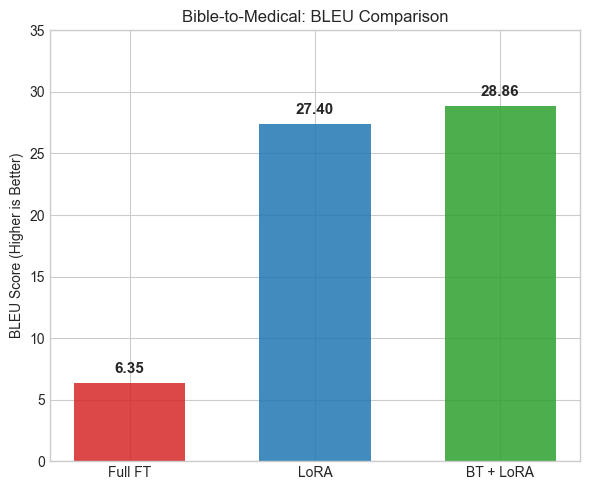

Generating chrF plot...


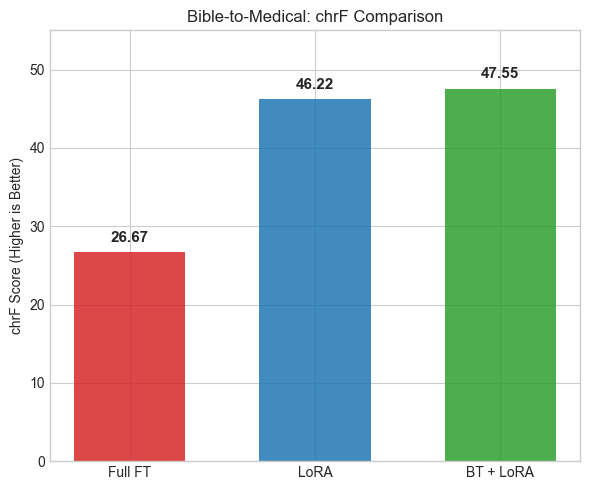

Generating COMET plot...


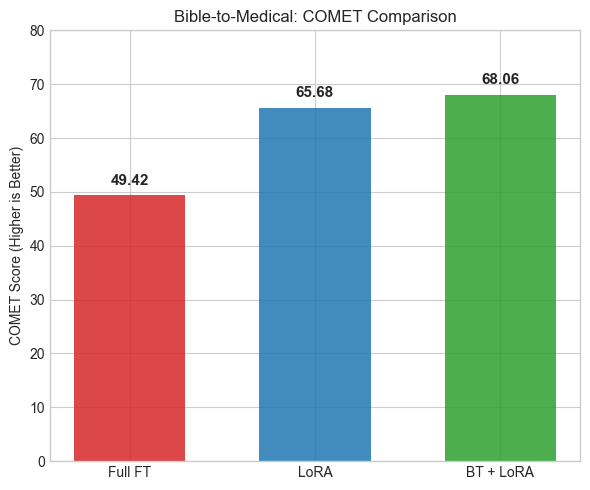

Generating Parameters plot...


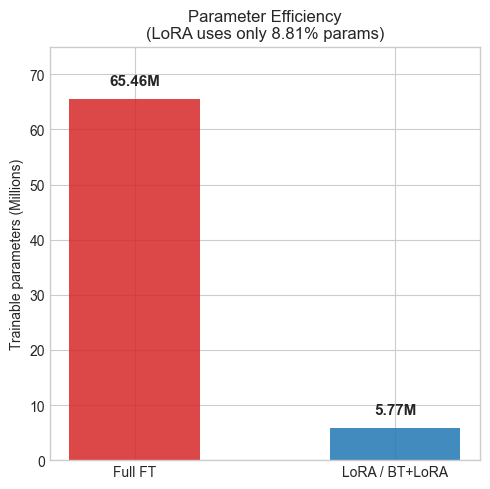


Saved all plots in ./figures/


In [ ]:

import matplotlib.pyplot as plt

# ================= Data preparation =================
# Experiment names
METHODS = ["Full FT", "LoRA", "BT + LoRA"]
# Color configuration: red(Baseline), blue(LoRA), green(BT+LoRA)
COLORS = ['#d62728', '#1f77b4', '#2ca02c']

# 1. BLEU Score (n-gram precision)
DATA_BLEU = [6.35, 27.40, 28.86]

# 2. chrF Score (character level match)
DATA_CHRF = [26.67, 46.22, 47.55]

# 3. COMET Score (semantic similarity)
DATA_COMET = [49.42, 65.68, 68.06]

# 4. Parameters (Millions)
DATA_PARAMS = [65.46, 5.77] # Full FT vs LoRA
METHODS_PARAMS = ["Full FT", "LoRA / BT+LoRA"]


def plot_metric_bar(metric_name, data, out_path, y_limit=None):
    
    plt.figure(figsize=(6, 5))
    
    
    bars = plt.bar(METHODS, data, color=COLORS, alpha=0.85, width=0.6)
    
    # Add labels
    plt.ylabel(f"{metric_name} Score (Higher is Better)")
    plt.title(f"Bible-to-Medical: {metric_name} Comparison")
    
    
    if y_limit:
        plt.ylim(0, y_limit)
    else:
        plt.ylim(0, max(data) * 1.15) 

    
    for i, v in enumerate(data):
        plt.text(i, v + (max(data)*0.02), f"{v:.2f}",
                 ha="center", va="bottom", fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()
    plt.close()


def plot_params(out_path):

    plt.figure(figsize=(5, 5))
    bars = plt.bar(METHODS_PARAMS, DATA_PARAMS, color=['#d62728', '#1f77b4'], alpha=0.85, width=0.5)
    
    
    percent = (DATA_PARAMS[1] / DATA_PARAMS[0]) * 100
    
    plt.ylabel("Trainable parameters (Millions)")
    plt.title(f"Parameter Efficiency\n(LoRA uses only {percent:.2f}% params)")
    
    
    plt.ylim(0, 75)

    for i, v in enumerate(DATA_PARAMS):
        plt.text(i, v + 2, f"{v:.2f}M",
                 ha="center", va="bottom", fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()
    plt.close()


def main():
    os.makedirs("figures", exist_ok=True)

    # BLEU
    print("Generating BLEU plot...")
    plot_metric_bar("BLEU", DATA_BLEU, "figures/bible_medical_bleu.png", y_limit=35)

    # chrF
    print("Generating chrF plot...")
    plot_metric_bar("chrF", DATA_CHRF, "figures/bible_medical_chrf.png", y_limit=55)

    # COMET 
    print("Generating COMET plot...")
    plot_metric_bar("COMET", DATA_COMET, "figures/bible_medical_comet.png", y_limit=80)
    

    print("Generating Parameters plot...")
    plot_params("figures/bible_medical_params.png")

    print("\nSaved all plots in ./figures/")


if __name__ == "__main__":
    main()